Импорт библиотек

In [17]:
%matplotlib inline

import os

import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2

from PIL import Image

import scipy.ndimage as ndimage 
from scipy.interpolate import RectBivariateSpline 

Описание функций

In [18]:
def get_color_mask(img, lower, upper):
    '''
    Function to mask-out the image in specified BGR boundaries

    input
    img:            np.array HxWx3 image (BGR !!!)
    lower:          np.array with the size of 3. Lower BGR boundaries
    upper:          np.array with the size of 3. Lower BGR boundaries

    output
    mask_image:       np.array HxW mask (0-n-255)
    '''
    low = np.array(lower)
    up = np.array(upper)
    mask = cv2.inRange(img, low, up)
    #mask = 255 - mask 
    return mask

In [19]:
def display_images(ch,initial_image, upscaled_image, out_image):
    """Display the initial, magnified, and result images for comparison."""
    plt.figure(figsize=(12, 4))
    t = 'Channel ' + str(ch)
    plt.suptitle(t, fontsize=20)

    plt.subplot(1, 3, 1)
    plt.imshow(initial_image, cmap='gray')
    plt.title('Initial',fontsize = 15)

    plt.subplot(1, 3, 2)
    plt.imshow(upscaled_image, cmap='gray')
    plt.title('Upscaled',fontsize = 15)

    plt.subplot(1, 3, 3)
    plt.imshow(out_image, cmap='gray')
    plt.title('Processed',fontsize = 15)

    plt.tight_layout()
    plt.show()

In [20]:
def safe_add(arr, x, y, val):
    #Добавляет значение `val` к элементу `arr[x, y]`, если `x` и `y` находятся в пределах границ массива
        arr[x, y] += val

In [21]:
def one_channel_processing(ch,i_in,scale_factor,gain,k,my_mask):
    # step 1
    number_row_initial, number_column_initial = i_in.shape
    resized_width = int(number_column_initial * scale_factor)
    resized_height = int(number_row_initial * scale_factor)
    i_resized = cv2.resize(i_in, (resized_width, resized_height), interpolation=cv2.INTER_LANCZOS4) # Апскейл с использованием cv2.resize() # Используем интерполяцию
    i_resized[i_resized < 0] = 0    # Обрезка отрицательных значений пикселей.
    i_resized = np.pad(i_resized, 10, mode='reflect')   # Паддинг
    number_row, number_column = i_resized.shape

    # step 2
    i_resized_smoothed = cv2.GaussianBlur(i_resized, (9, 9), 40) # (x,x) - размер ядра, y - стандартное отклонение
    i_normalized = i_resized_smoothed / (ndimage.gaussian_filter(i_resized_smoothed, 10) + 1e-5) # нормализация

    # step 3
    Sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])    # Вычисляем градиенты с помощью свертки с ядром Собеля
    Sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])    # Вычисляем градиенты с помощью свертки с ядром Собеля
    gradient_y = ndimage.convolve(i_normalized, Sobel_x, mode='reflect')
    gradient_x = ndimage.convolve(i_normalized, Sobel_y, mode='reflect')
    gradient_x = gradient_x / (i_normalized + 1e-5)    # Нормализуем градиенты
    gradient_y = gradient_y / (i_normalized + 1e-5)    # Нормализуем градиенты

    # step 4: Вычисляем смещение пикселей на основе градиента
    gain_value = gain
    displacement_x = gain_value * gradient_x
    displacement_y = gain_value * gradient_y
    displacement_x[np.abs(displacement_x) > 5] = 0
    displacement_y[np.abs(displacement_y) > 5] = 0
    
    # step 5
    i_out = np.zeros((number_row, number_column))
    for nx in range(10, number_row - 10):   # по строкам масштабированного изображения
        for ny in range(10, number_column - 10):    # по столбцам масштабированного изображения
            if(my_mask[nx-10][ny-10]!=0):
                weighted1 = (1 - abs(displacement_x[nx, ny] - int(displacement_x[nx, ny]))) * (
                            1 - abs(displacement_y[nx, ny] - int(displacement_y[nx, ny])))
                # Вычисляем веса для четырех соседних пикселей на основе дробной части смещений
                weighted2 = (1 - abs(displacement_x[nx, ny] - int(displacement_x[nx, ny]))) * abs(
                    displacement_y[nx, ny] - int(displacement_y[nx, ny]))
                weighted3 = abs(displacement_x[nx, ny] - int(displacement_x[nx, ny])) * (
                            1 - abs(displacement_y[nx, ny] - int(displacement_y[nx, ny])))
                weighted4 = abs(displacement_x[nx, ny] - int(displacement_x[nx, ny])) * abs(
                    displacement_y[nx, ny] - int(displacement_y[nx, ny]))

                coordinate1 = [int(displacement_x[nx, ny]), int(displacement_y[nx, ny])]
                coordinate2 = [int(displacement_x[nx, ny]),
                            int(displacement_y[nx, ny]) + int(np.sign(displacement_y[nx, ny]))]
                coordinate3 = [int(displacement_x[nx, ny]) + int(np.sign(displacement_x[nx, ny])),
                            int(displacement_y[nx, ny])]
                coordinate4 = [int(displacement_x[nx, ny]) + int(np.sign(displacement_x[nx, ny])),
                            int(displacement_y[nx, ny]) + int(np.sign(displacement_y[nx, ny]))]

                # Добавляем проверки границ!
                safe_add(i_out, nx + coordinate1[0], ny + coordinate1[1], weighted1 * i_resized[nx, ny])
                safe_add(i_out, nx + coordinate2[0], ny + coordinate2[1], weighted2 * i_resized[nx, ny])
                safe_add(i_out, nx + coordinate3[0], ny + coordinate3[1], weighted3 * i_resized[nx, ny])
                safe_add(i_out, nx + coordinate4[0], ny + coordinate4[1], weighted4 * i_resized[nx, ny])
            else:
                i_out[nx][ny] = i_resized[nx][ny]

    
    # step 6: Фильтрация
    i_out_FILTRATED = ndimage.gaussian_filter(i_out, sigma=1.5) # Важен выбор sigma

    # step 7: Удаляем паддинг
    i_out_FILTRATED = i_out_FILTRATED[10:-10, 10:-10]
    i_resized = i_resized[10:-10, 10:-10]

    # step 8
    directory = 'test_images/images_in_progress'
    filename = 'MAIN2_test'+str(k)+'_channel'+str(ch)+'_UPSCALED.jpg'
    #filename = 'MAIN_test1_channel0_UPSCALED.jpg'
    r = i_resized
    f = os.path.join(directory, filename)  
    cv2.imwrite(f, r)

    # step 8
    directory = 'test_images/images_in_progress'
    filename = 'MAIN2_test'+str(k)+'_channel'+str(ch)+'_OUT.jpg'
    r = i_out_FILTRATED
    f = os.path.join(directory, filename)  
    cv2.imwrite(f, r)

    # step 9: Показываем результаты обработки канала
    #f1 = 'test_images/images_in_progress/MAIN2_test'+str(k)+'_jpg_channel'+str(ch)+'_ORIG.jpg'
    #orig = Image.open(f1) 
    #f2 = 'test_images/images_in_progress/MAIN2_test'+str(k)+'_channel'+str(ch)+'_UPSCALED.jpg'
    #upsc = Image.open(f2) 
    #f3 = 'test_images/images_in_progress/MAIN2_test'+str(k)+'_channel'+str(ch)+'_OUT.jpg'
    #out = Image.open(f3) 
    #display_images(ch, orig, upsc, out)
      

Обработка изображений

In [22]:
def main_function(k,gain,scale_factor):
    # Создание маски
    directory = 'test_images'
    filename = 'test'+str(k)+'_jpg.jpg'
    f = os.path.join(directory, filename) 
    img = cv2.imread(f)
    new_mask=get_color_mask(img,[0,0,0], [255,200,255])
    h, w = new_mask.shape
    new_mask_image = np.zeros([h,w,3],dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            for q in range(3):
                new_mask_image[i][j][q]=new_mask[i][j]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_m = cv2.bitwise_and(img, img, mask = new_mask)
    #fig, axs = plt.subplots(1, 3, figsize=(15*1,6*1))
    #fig.suptitle('Creating a mask',fontsize = 20)
    #axs[0].imshow(img) 
    #axs[0].set_title('Initial image',fontsize = 15)
    #axs[1].imshow(new_mask_image) 
    #axs[1].set_title('Mask',fontsize = 15)
    #axs[2].imshow(img_m) 
    #axs[2].set_title('Masked image',fontsize = 15)

    current_mask = np.zeros([2*h,2*w],dtype=np.uint8) #увеличиваем масштаб маски в scale_factor раз
    for i in range(2*h):
        for j in range(2*w):
            current_mask[i][j]=new_mask[i//2][j//2]
    current_mask_image = np.zeros([2*h,2*w,3],dtype=np.uint8)
    for i in range(2*h):
        for j in range(2*w):
            for q in range(3):
                current_mask_image[i][j][q]=current_mask[i][j]


    # Обработка по каналам
    directory = 'test_images'
    filename = 'test'+str(k)+'_jpg.jpg'
    f = os.path.join(directory, filename)  
    image = Image.open(f) 
    t1j = np.array(image) 
    t1j = 255 - t1j
    directory = 'test_images/images_in_progress'
    for ch in range(3):
        t1j0 = t1j[:,:,ch]
        filename = 'MAIN2_test'+str(k)+'_jpg_channel'+str(ch)+'_ORIG.jpg'
        f = os.path.join(directory, filename)  
        cv2.imwrite(f, t1j0)
        image = Image.open(f) 
        i_in = np.array(image) 
        one_channel_processing(ch,i_in,scale_factor,gain,k,current_mask)

    # Совмещаем обработанные каналы
    f0 = 'test_images/images_in_progress/MAIN2_test'+str(k)+'_channel'+str(0)+'_OUT.jpg'
    ch0 = cv2.imread(f0)
    f1 = 'test_images/images_in_progress/MAIN2_test'+str(k)+'_channel'+str(1)+'_OUT.jpg'
    ch1 = cv2.imread(f1)
    f2 = 'test_images/images_in_progress/MAIN2_test'+str(k)+'_channel'+str(2)+'_OUT.jpg'
    ch2 = cv2.imread(f2)

    res_h, res_w, c = ch0.shape
    res = np.zeros([res_h,res_w,3])
    for i in range(res_h):
        for j in range(res_w):
            # До этого работали с cv2, где изображения представлены в BGR, поэтому ch0 -- синий, ch1 -- зелёный, ch2 -- красный
            res[i][j][0]=255-ch2[i][j][2]
            res[i][j][1]=255-ch1[i][j][1]
            res[i][j][2]=255-ch0[i][j][0]

    directory = 'test_images'
    filename = 'Result'+str(k)+'.jpg'
    r = res
    f = os.path.join(directory, filename)  
    cv2.imwrite(f, r)

    # Показываем результаты
    directory = 'test_images'
    i_filename = 'test'+str(k)+'_jpg.jpg'
    f = os.path.join(directory, i_filename) 
    initial = cv2.imread(f)
    r_filename = 'Result'+str(k)+'.jpg'
    f = os.path.join(directory, r_filename) 
    result = cv2.imread(f)

    initial = cv2.cvtColor(initial, cv2.COLOR_BGR2RGB)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 2, figsize=(12*1,6*1))
    t = 'The result of processing ' + i_filename 
    fig.suptitle(t, fontsize = 15)
    axs[0].imshow(initial) 
    axs[1].imshow(result) 

In [23]:
# Константы
N =10 # Количество тестовых изображений 
gain = 2
scale_factor = 2 # Коэффициент масштабирования

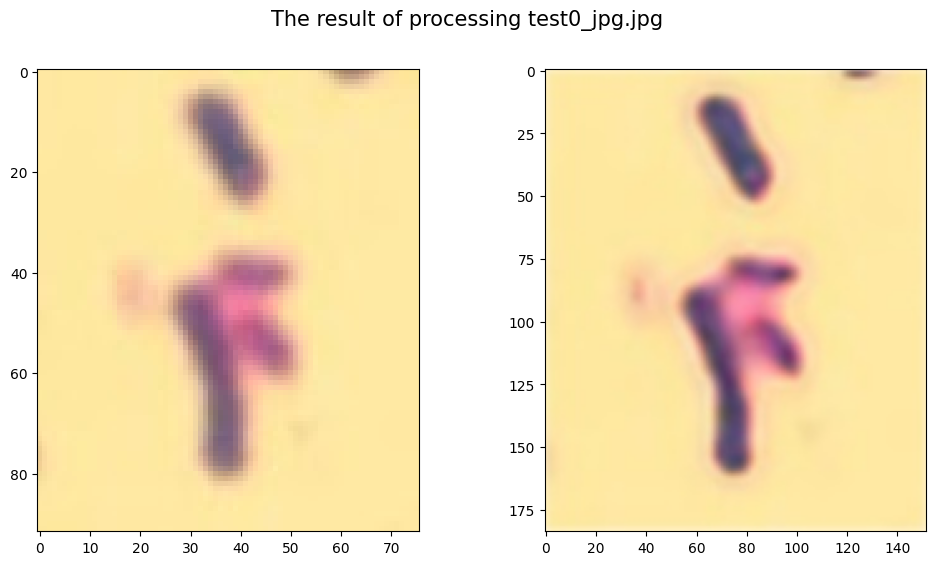

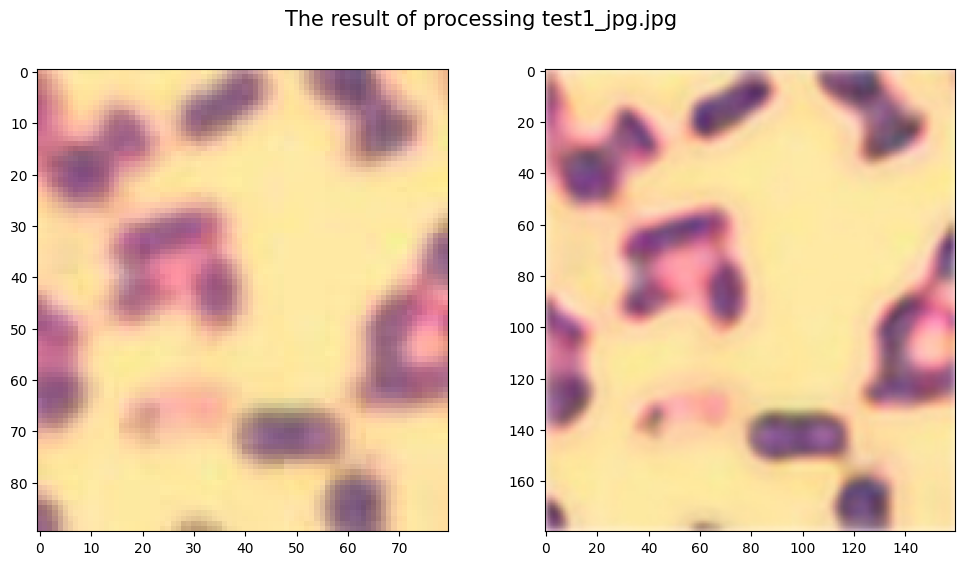

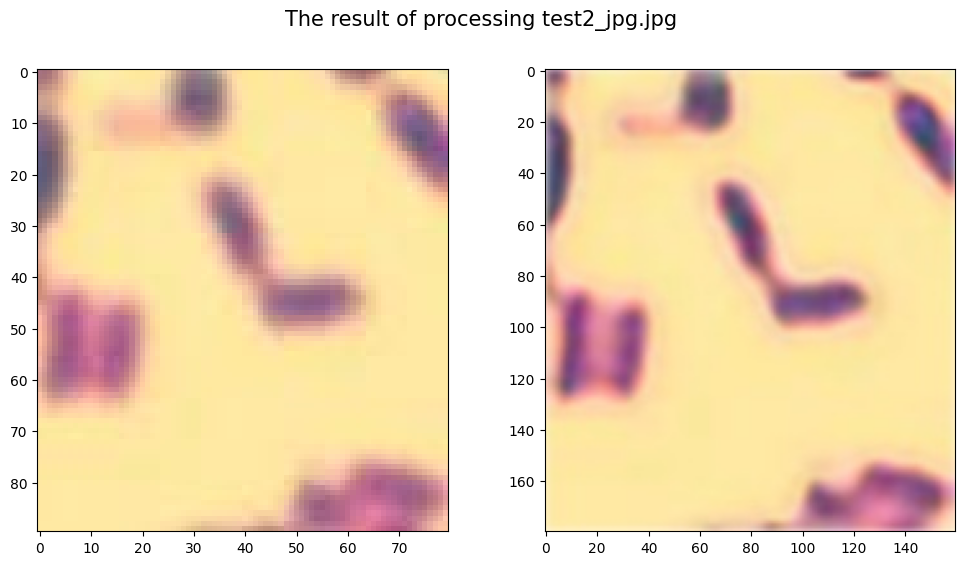

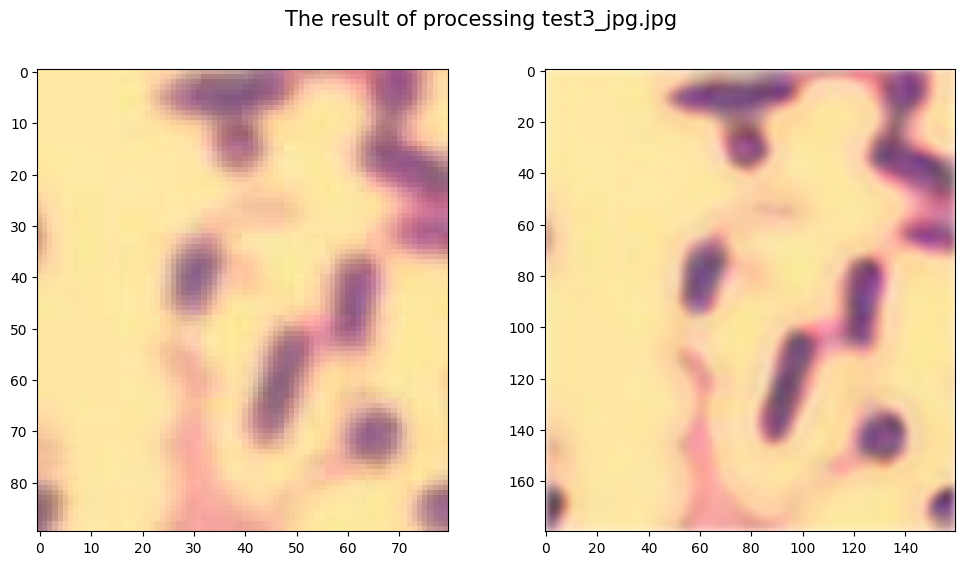

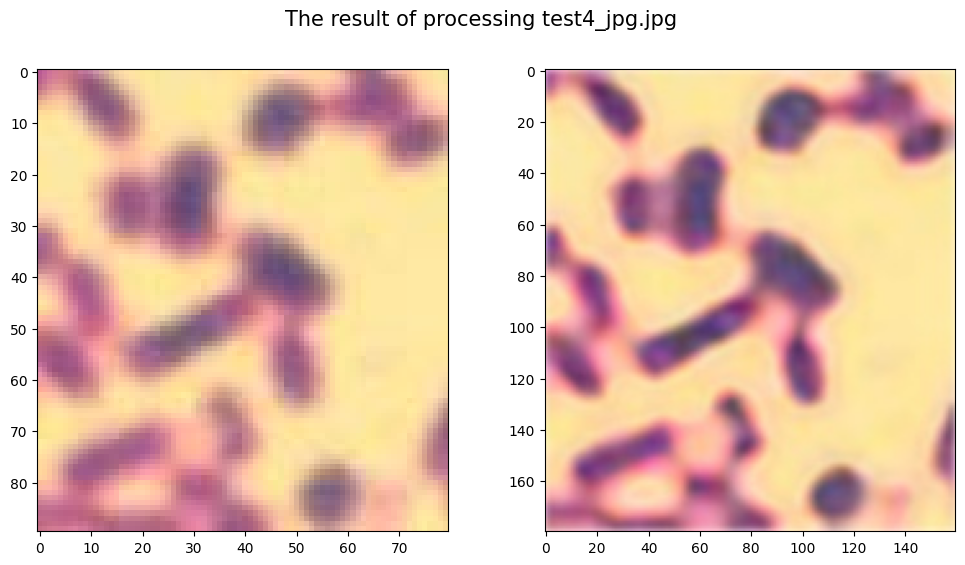

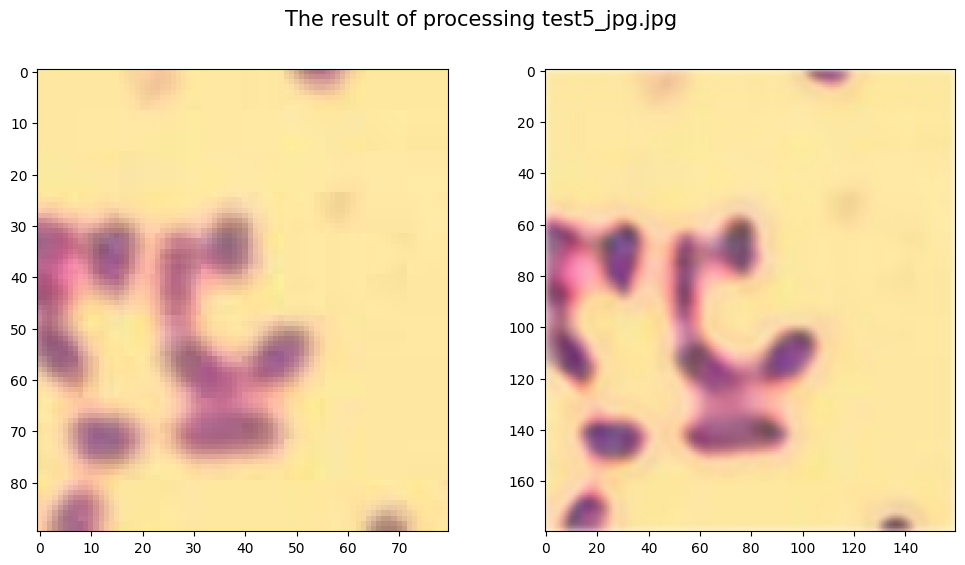

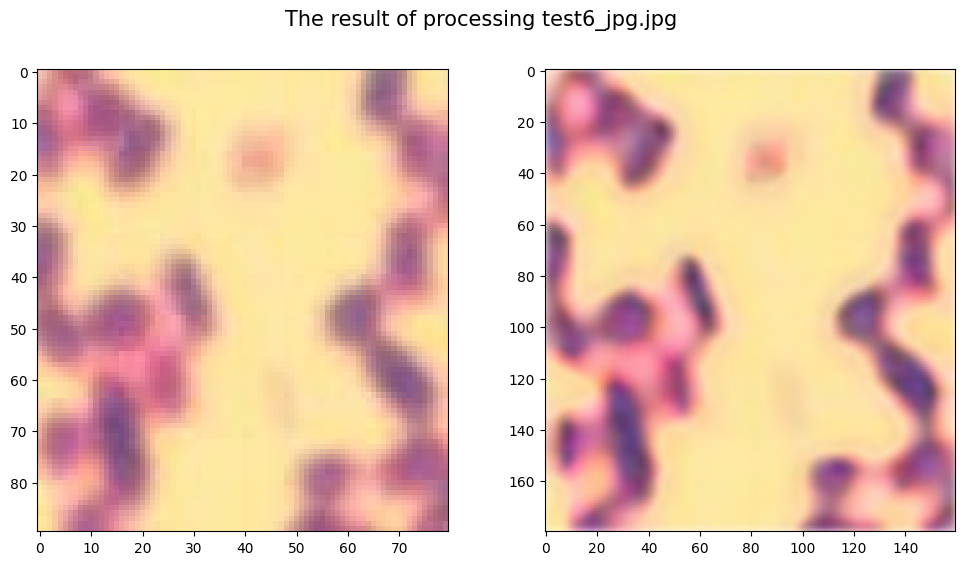

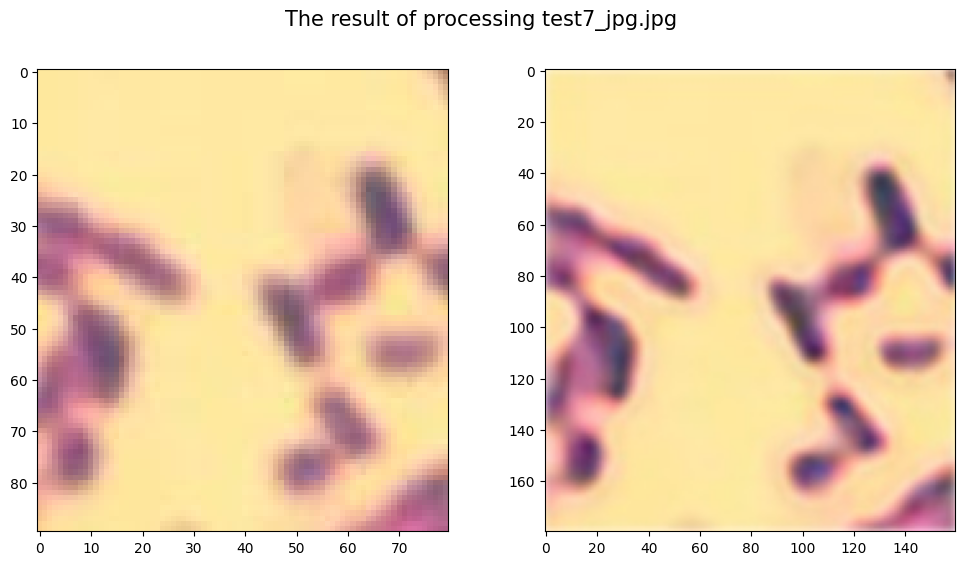

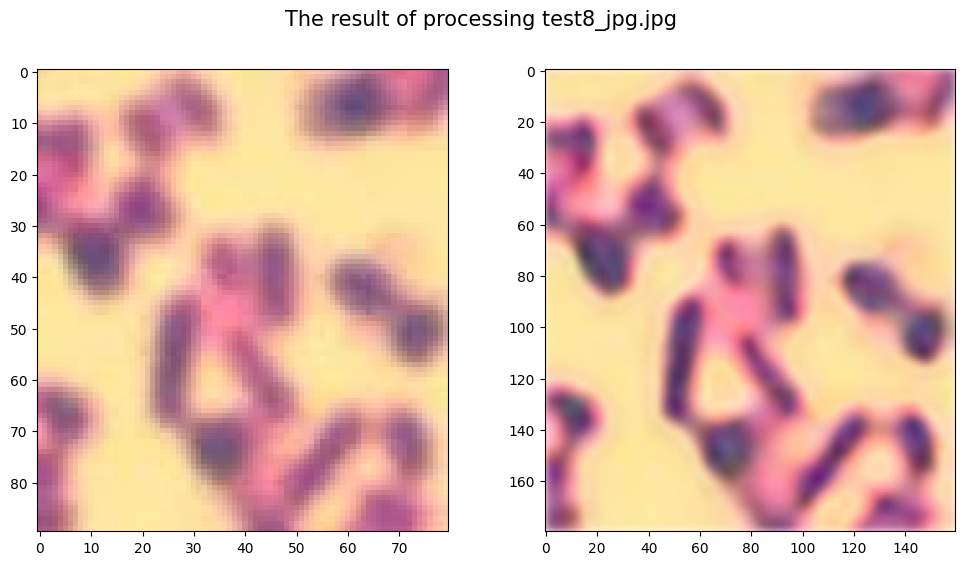

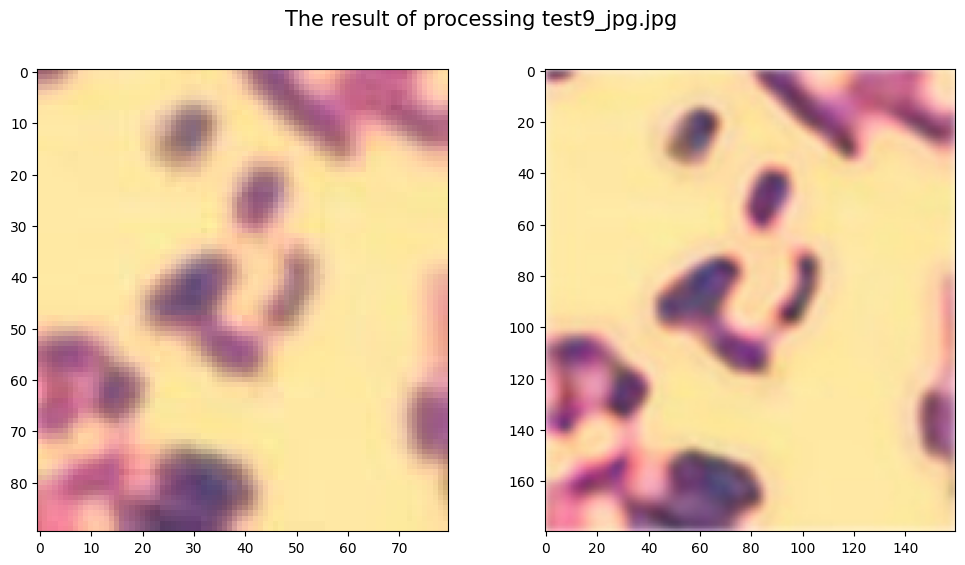

In [24]:
for k in range(N): # k -- омер тестового изображения (имя в формате test'+str(k)+'_jpg.jpg')
    main_function(k,gain,scale_factor)